In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree

# Decision tree modelling - Baseline

Opening test & train data

In [5]:
X_train_nn=pd.read_csv('/workspaces/Decis_Tree_Diabetes/data/processed/X_train_nn.csv')
X_test_nn=pd.read_csv('/workspaces/Decis_Tree_Diabetes/data/processed/X_test_nn.csv')

y_train=pd.read_csv("/workspaces/Decis_Tree_Diabetes/data/processed/y_train.txt", header=None)
y_test=pd.read_csv("/workspaces/Decis_Tree_Diabetes/data/processed/y_test.txt", header=None)

#the code above imports y as dataframe, below I convert it to a pd series
y_train=y_train[0]
y_test=y_test[0]

In [6]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train_nn, y_train)

DecisionTreeClassifier(random_state=42)

## Visualising tree

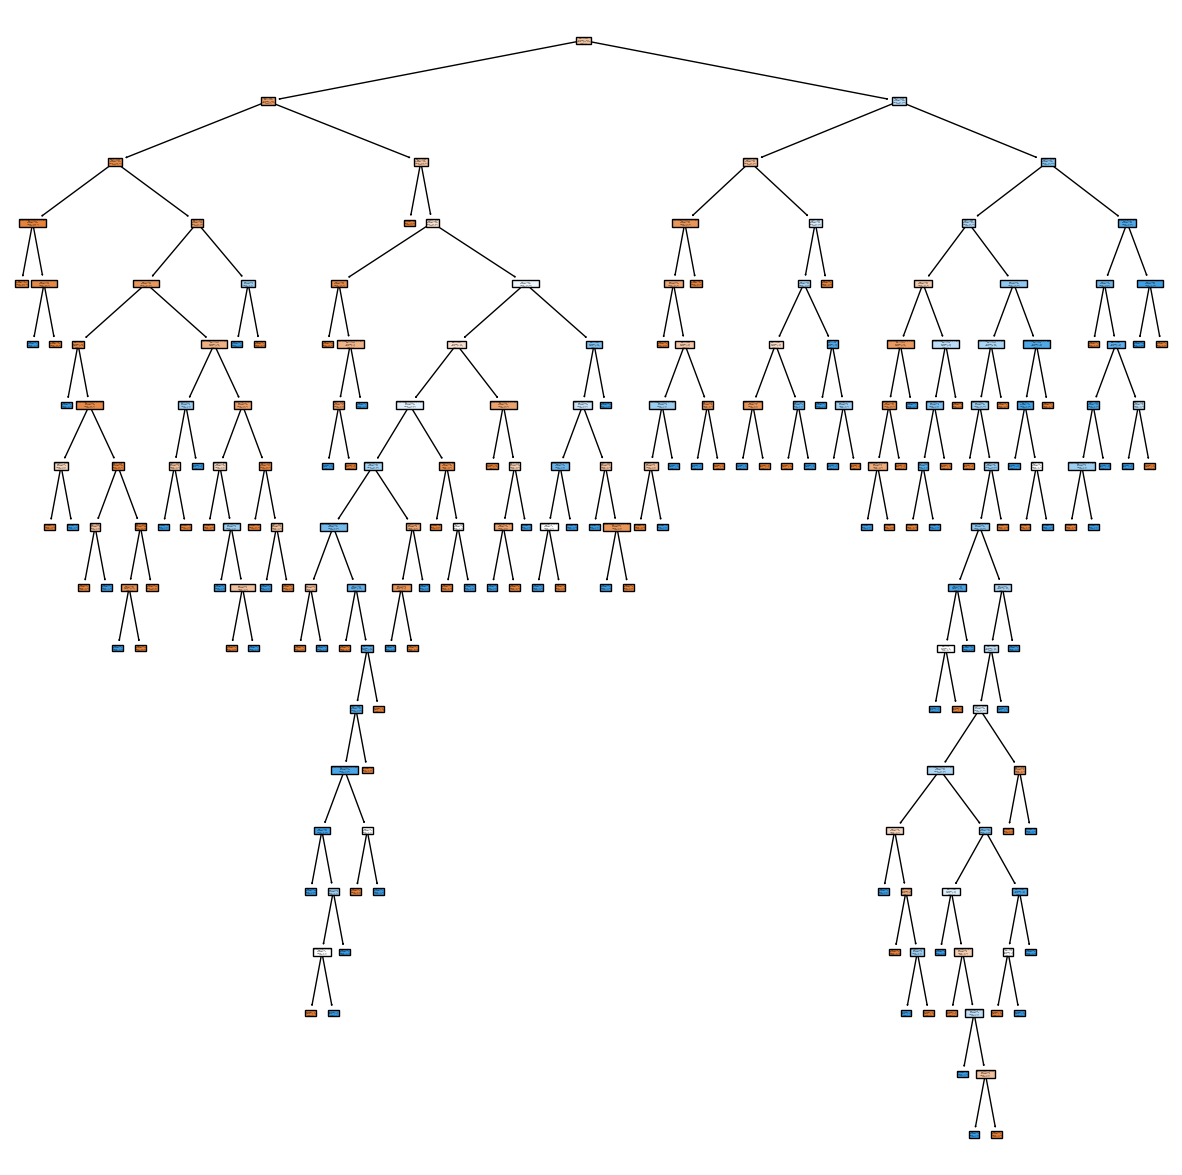

In [7]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train_nn.columns), class_names = ["0", "1"], filled = True)

plt.show()

In [8]:
y_pred = model.predict(X_test_nn)

## Evaluating model performance

Comparing accuracy score of train vs test predictions:

The difference of roughly 0.3 points suggests that the trained model may be suffering from overfitting, hence the model fits too well the training data but the results do not generalise to a new dataset. This overfitting is expected given the high number of tree nodes observed before.

Still, a baseline score of 74% is not too bad to begin with since this model is just the baseline

In [9]:
y_pred_train=model.predict(X_train_nn)
print('Accuracy train: ', accuracy_score(y_pred_train,y_train))
print('Accuracy test: ', accuracy_score(y_pred,y_test))

Accuracy train:  1.0
Accuracy test:  0.7467532467532467


Confusion matrix

The trained model has 19 false negatives, meaning that 19 patients were missdiagnosed, when indeed, they had diabetes. In contrast, the model predicted that 20 patients had diabetes when in reality the did not have it.  

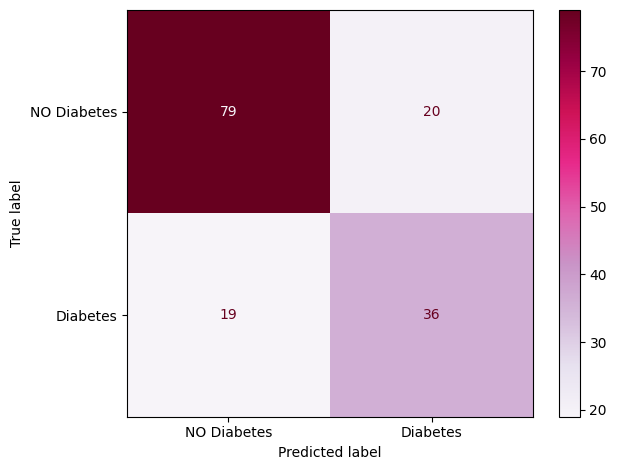

In [10]:
diabetes_cm = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred), display_labels = ['NO Diabetes', 'Diabetes']    )
# plot CM
diabetes_cm.plot(cmap = 'PuRd')
plt.tight_layout()
plt.show()

Classification report:

Statistics of precision and recall are high for patients with no diabetes, meaning that the model did a better job predicting the class.

On the other hand, the moded did not perform as well for patients with diabetes. Only 64% of the **predictions** of diabetes were correct and only 65% of the **real** cases of diabetes were correclty predicted by the trained model. Ideally, the optimal model should predict more of the real cases of diabetes

In [11]:
class_report=metrics.classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80        99
           1       0.64      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



# Hyperparameter tunning

Setting hyperparameters, randomised search, and fitting model

In [12]:
hyprms={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter':['best', 'random'],
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1,50,1),
    'min_samples_split': np.arange(2, 5, 1)
}

score=['accuracy', 'f1']

In [13]:
model_cv=RandomizedSearchCV(model, hyprms, scoring=score, refit='accuracy',n_iter = 500, cv = 5, random_state = 42)

In [14]:
model_cv.fit(X_train_nn,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=500,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 3, 4]),
                                        'splitter': ['best', 'random']},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'f1'])

Obtaining best hyperparameters:

In [15]:
best_params=model_cv.best_params_

# Optimised model

In [16]:
model_opt=DecisionTreeClassifier(**best_params, random_state = 42)

In [17]:
model_opt.fit(X_train_nn, y_train)

dump(model_opt, open('/workspaces/Decis_Tree_Diabetes/models/dt_log_loss_depth3_minsampl3_seed42.pk', 'wb'))

## Visualising tree

The new tree has 6 levels, including root, and it is much easier to visualise

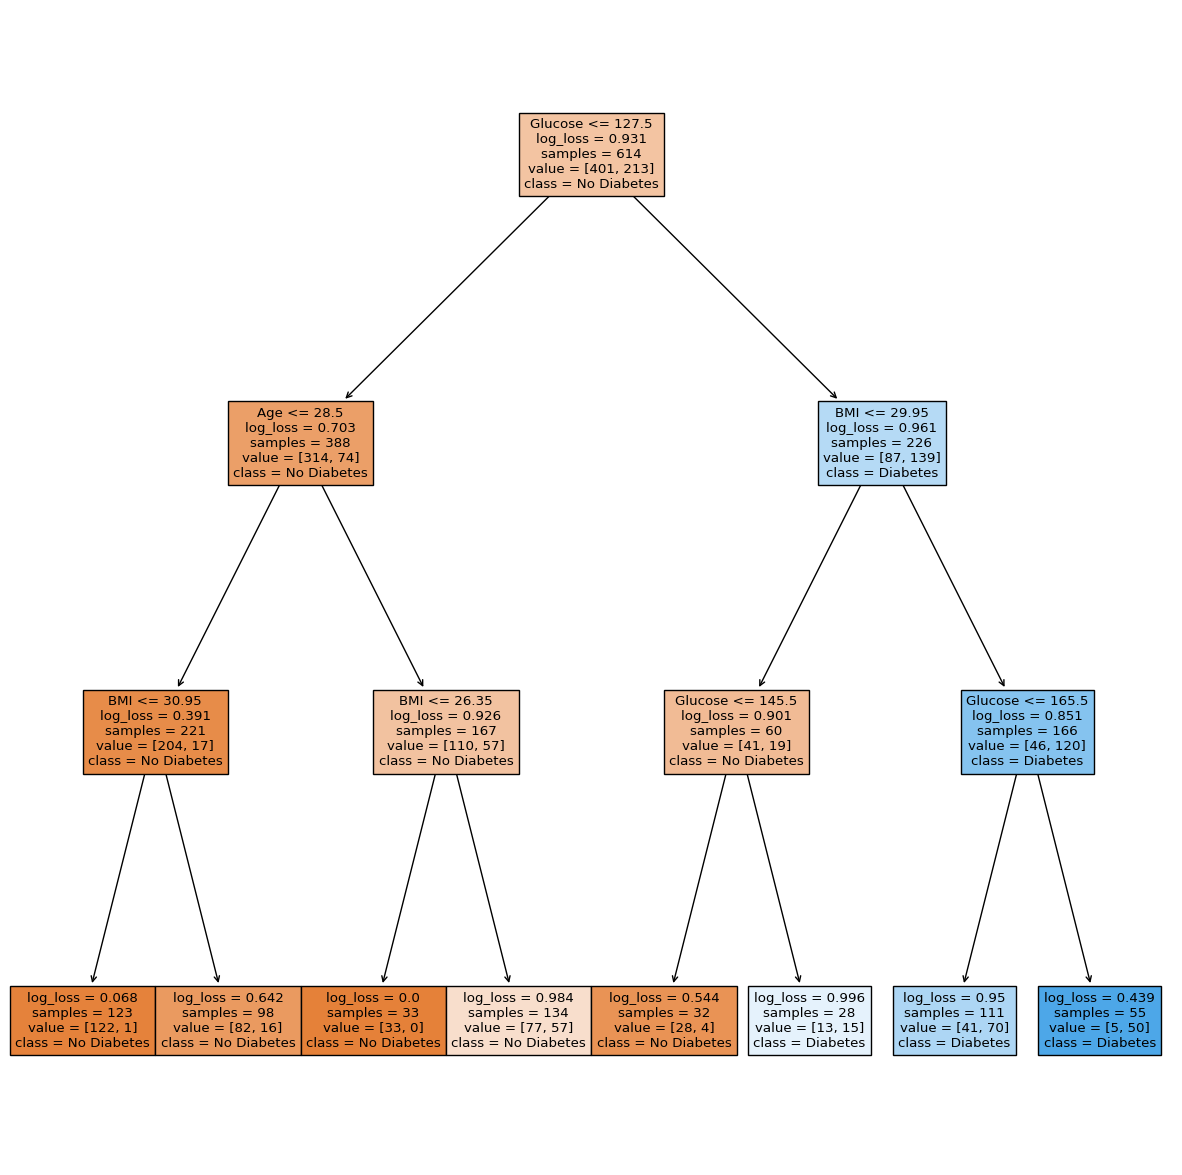

In [18]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model_opt, feature_names = list(X_train_nn.columns), class_names = ["No Diabetes", "Diabetes"], filled = True)

plt.show()

## Evaluating model performance

**Accuracy**

The model accurately predicts 76% of classes, similar to the baseline model. However, now the overfitting is not major since both measures of accuracy in train and test data are now much closer.

In [19]:
y_pred_train=model_opt.predict(X_train_nn)
y_pred=model_opt.predict(X_test_nn)
print('Accuracy train: ', accuracy_score(y_pred_train,y_train))
print('Accuracy test: ', accuracy_score(y_pred,y_test))

Accuracy train:  0.7768729641693811
Accuracy test:  0.7662337662337663


**Confusion matrix:**

The model improved on detecting the patients who do not have diabetes but there are still 20 patients missdiagnosed.

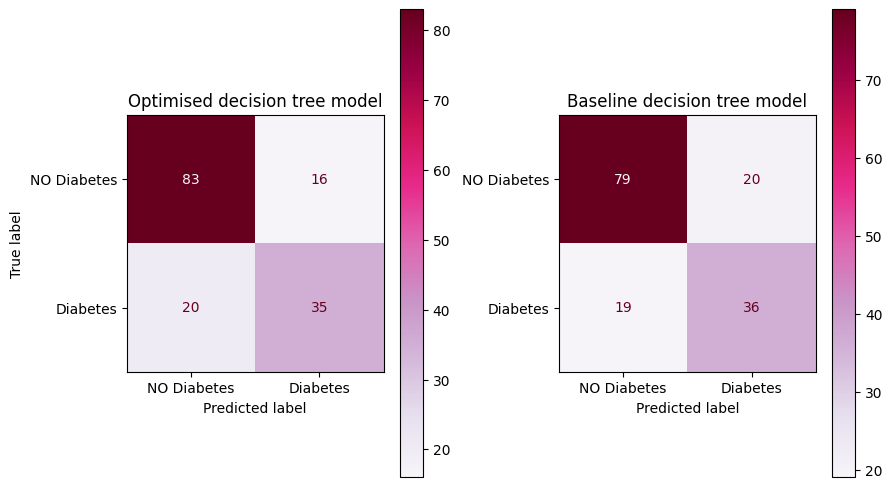

In [20]:
diabetes_cm2 = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred), display_labels = ['NO Diabetes', 'Diabetes']    )
# plot CM
fig, ax= plt.subplots(1,2, figsize=(9,5))
diabetes_cm2.plot(cmap = 'PuRd', ax=ax[0])
ax[0].set_title('Optimised decision tree model')

diabetes_cm.plot(cmap = 'PuRd', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('Baseline decision tree model')

plt.tight_layout()
plt.show()

**Classification report:**

As compared to the baseline model, the class 'no diabetes' remain unchaged in precision but recall improved 0.04 points. Meaning that now, out of the **real** no-diabetes cases, 84% were corretly predicted by the model.

Although the confusion matrix did not change much in baseline versus optimised models, the classification report shows a closer look to the model performance on each class and provides a more optimistic result. Precision improved by 0.04, meaning that the model now predicted correctly 64% of the diabetes cases, versus 60% of baseline model. Recall improved by 0.01 points, meaning that now, out of the real cases of diabetes, the model correctly predicted 65% of the cases, as compared to 64% in the baseline model

In [21]:
print('Baseline model Clasiffication report: \n', class_report)
print('\n Optemised model Clasiffication report: \n', metrics.classification_report(y_test, y_pred))

Baseline model Clasiffication report: 
               precision    recall  f1-score   support

           0       0.81      0.80      0.80        99
           1       0.64      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


 Optemised model Clasiffication report: 
               precision    recall  f1-score   support

           0       0.81      0.84      0.82        99
           1       0.69      0.64      0.66        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.76       154

